<h1>Детектирование фродовых транзакций (V1)</h1>

<h4>Датасет: https://www.kaggle.com/datasets/kartik2112/fraud-detection</h4>

About the Dataset

This is a simulated credit card transaction dataset containing legitimate and fraud transactions from the duration 1st Jan 2019 - 31st Dec 2020. It covers credit cards of 1000 customers doing transactions with a pool of 800 merchants.

Source of Simulation

This was generated using Sparkov Data Generation | Github tool created by Brandon Harris. This simulation was run for the duration - 1 Jan 2019 to 31 Dec 2020. The files were combined and converted into a standard format.

Information about the Simulator

I do not own the simulator. I used the one used by Brandon Harris and just to understand how it works, I went through few portions of the code. This is what I understood from what I read:

The simulator has certain pre-defined list of merchants, customers and transaction categories. And then using a python library called "faker", and with the number of customers, merchants that you mention during simulation, an intermediate list is created.

After this, depending on the profile you choose for e.g. "adults 2550 female rural.json" (which means simulation properties of adult females in the age range of 25-50 who are from rural areas), the transactions are created. Say, for this profile, you could check "Sparkov | Github | adults_2550_female_rural.json", there are parameter value ranges defined in terms of min, max transactions per day, distribution of transactions across days of the week and normal distribution properties (mean, standard deviation) for amounts in various categories. Using these measures of distributions, the transactions are generated using faker.

What I did was generate transactions across all profiles and then merged them together to create a more realistic representation of simulated transactions.

In [ ]:


import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid')

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/fraudTrain.csv', index_col=0)
test_data = pd.read_csv('/content/drive/MyDrive/fraudTest.csv', index_col=0)

In [ ]:
df = pd.concat([train_data,test_data])

In [ ]:
df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   cc_num                 int64  
 2   merchant               object 
 3   category               object 
 4   amt                    float64
 5   first                  object 
 6   last                   object 
 7   gender                 object 
 8   street                 object 
 9   city                   object 
 10  state                  object 
 11  zip                    int64  
 12  lat                    float64
 13  long                   float64
 14  city_pop               int64  
 15  job                    object 
 16  dob                    object 
 17  trans_num              object 
 18  unix_time              int64  
 19  merch_lat              float64
 20  merch_long             float64
 21  is_fraud               int64  
dtypes: float64(5), int64(5),

In [ ]:
customer = df['cc_num'].to_list()
customer = set(customer)


In [ ]:
len(customer)

999

In [ ]:
print(d.keys())

dict_keys([4110266553600176127, 3524574586339330, 4045036286570100739, 3596217206093829, 213136802746375, 4683520018489354, 342035762534413, 4006047418382, 4348786085525522, 4561546772499, 4788103653396, 30596478689301, 4450831335606294, 3543299015720986, 3517527805128735, 4764202053279782, 4134456652433447, 4124536010991657, 4989847570577635369, 4018105808392773675, 4500002361389, 3502088871723054, 371683116218417, 6535328428560433, 4488941175228467, 2706977570537524, 6544734391390261, 38057513087029, 370818583810103, 4087542780207162, 30248898834493, 6011518448009279, 3545578418030657, 3585052663373890, 3541554378551366, 4714017207228610634, 4162872756672112717, 3531129874770000, 2610529083834453, 565399283797, 4129767952109660, 213153151785052, 3560797065840735, 345225948700767, 3520550088202337, 180097223252063, 4570636521433188, 3551217896304745, 4477156602511939689, 30092964733035, 4951647200979051, 4119762878330989, 3506040590383211, 3550412175018089, 4295296907373, 213107169859

In [ ]:
df.loc[df.n == "d",["a","b"]].to_dict('records')
#[4, 6]

[{'a': 2, 'b': 8}, {'a': 4, 'b': 6}]

In [ ]:
train_data["trans_date_trans_time"] = pd.to_datetime(train_data["trans_date_trans_time"])
train_data["dob"] = pd.to_datetime(train_data["dob"])
test_data["trans_date_trans_time"] = pd.to_datetime(test_data["trans_date_trans_time"])
test_data["dob"] = pd.to_datetime(test_data["dob"])
train_data['age'] = train_data['trans_date_trans_time'] - train_data['dob']
test_data['age'] = test_data['trans_date_trans_time'] - test_data['dob']


In [ ]:
train_data['age'] = train_data['age'].apply(lambda x: x.days/365.2425 )

In [ ]:
test_data['age'] = test_data['age'].apply(lambda x: x.days/365.2425 )

In [ ]:
train_data.drop(columns=['cc_num','first', 'last', 'street', 'city', 'state', 'zip', 'dob', 'trans_num','trans_date_trans_time'],inplace=True)

In [ ]:
df.hea

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,age
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,30.815143
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,40.531975
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,56.951204
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,51.970951
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,32.764533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,...,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0,54.881346
555715,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,...,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0,21.013436
555716,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,...,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0,39.089098
555717,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,...,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0,55.045620


In [ ]:
train_data.dropna(ignore_index=True)

,merchant,category,amt,gender,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud,age
0,514,8,4.97,0,36.0788,-81.1781,3495,370,1325376018,36.011293,-82.048315,0,30.815143
1,241,4,107.23,0,48.8878,-118.2105,149,428,1325376044,49.159047,-118.186462,0,40.531975
2,390,0,220.11,1,42.1808,-112.2620,4154,307,1325376051,43.150704,-112.154481,0,56.951204
3,360,2,45.00,1,46.2306,-112.1138,1939,328,1325376076,47.034331,-112.561071,0,51.970951
4,297,9,41.96,1,38.4207,-79.4629,99,116,1325376186,38.674999,-78.632459,0,32.764533
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,499,0,15.56,1,37.7175,-112.4777,258,215,1371816728,36.841266,-111.690765,0,58.574783
1296671,2,1,51.70,1,39.2667,-77.5101,100,360,1371816739,38.906881,-78.246528,0,40.529237
1296672,599,1,105.93,1,32.9396,-105.8189,899,308,1371816752,33.619513,-105.130529,0,52.811488
1296673,509,1,74.90,1,43.3526,-102.5411,1126,485,1371816816,42.788940,-103.241160,0,39.842023


In [ ]:
encoder = LabelEncoder()
train_data["merchant"] = encoder.fit_transform(train_data["merchant"])
train_data["category"] = encoder.fit_transform(train_data["category"])
train_data["gender"] = encoder.fit_transform(train_data["gender"])
train_data["job"] = encoder.fit_transform(train_data["job"])

In [ ]:
train_data.head()

,merchant,category,amt,gender,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud,age
0,514,8,4.97,0,36.0788,-81.1781,3495,370,1325376018,36.011293,-82.048315,0,30.815143
1,241,4,107.23,0,48.8878,-118.2105,149,428,1325376044,49.159047,-118.186462,0,40.531975
2,390,0,220.11,1,42.1808,-112.2620,4154,307,1325376051,43.150704,-112.154481,0,56.951204
3,360,2,45.00,1,46.2306,-112.1138,1939,328,1325376076,47.034331,-112.561071,0,51.970951
4,297,9,41.96,1,38.4207,-79.4629,99,116,1325376186,38.674999,-78.632459,0,32.764533


In [ ]:
plt.figure(figsize=(24,20), dpi= 80)
sns.heatmap(train_data.corr(), xticklabels=train_data.corr().columns, yticklabels=train_data.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlogram of mtcars', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


NameError: name 'plt' is not defined

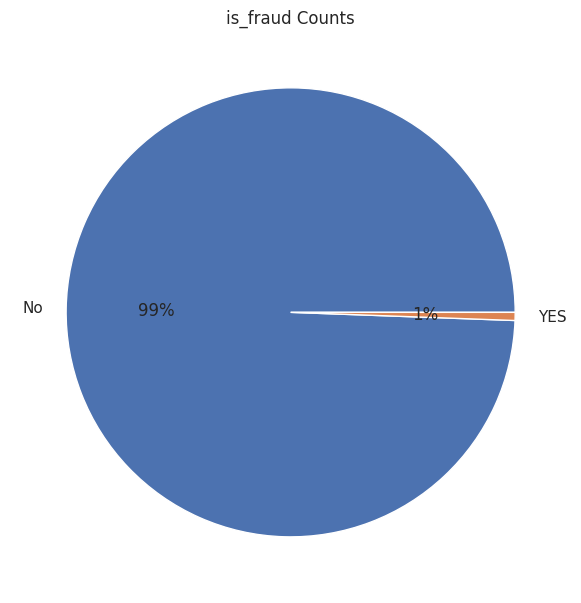

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

In [ ]:


exit_counts = train_data["is_fraud"].value_counts()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Subplot for the pie chart
plt.pie(exit_counts, labels=["No", "YES"], autopct="%0.0f%%")
plt.title("is_fraud Counts")
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()
exit_counts


In [ ]:
indexes = train_data.loc[train_data['is_fraud']==0].sample(frac=0.3).index
train_data = train_data.drop(indexes)


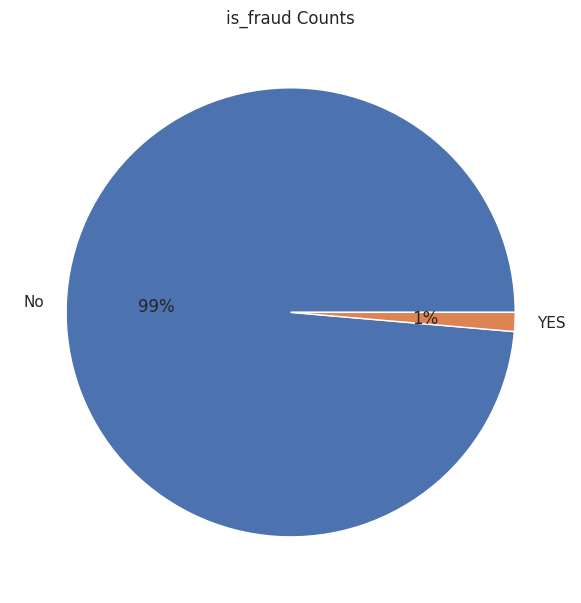

is_fraud
0    541451
1      7506
Name: count, dtype: int64

In [ ]:

exit_counts = train_data["is_fraud"].value_counts()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Subplot for the pie chart
plt.pie(exit_counts, labels=["No", "YES"], autopct="%0.0f%%")
plt.title("is_fraud Counts")
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()
exit_counts

In [ ]:
X = train_data.drop(columns=["is_fraud"], inplace = False)
Y = train_data["is_fraud"]

In [ ]:
test_data.drop(columns=['cc_num','first', 'last', 'street', 'city', 'state', 'zip', 'dob', 'trans_num','trans_date_trans_time'],inplace=True)

In [ ]:
encoder = LabelEncoder()
test_data["merchant"] = encoder.fit_transform(test_data["merchant"])
test_data["category"] = encoder.fit_transform(test_data["category"])
test_data["gender"] = encoder.fit_transform(test_data["gender"])
test_data["job"] = encoder.fit_transform(test_data["job"])



In [ ]:
test_data.dropna(ignore_index=True)

,merchant,category,amt,gender,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud,age
0,319,10,2.86,1,33.9659,-80.9355,333497,275,1371816865,33.986391,-81.200714,0,52.258431
1,591,10,29.84,0,40.3207,-110.4360,302,392,1371816873,39.450498,-109.960431,0,30.426361
2,611,5,41.28,0,40.6729,-73.5365,34496,259,1371816893,40.495810,-74.196111,0,49.668371
3,222,9,60.05,1,28.5697,-80.8191,54767,407,1371816915,28.812398,-80.883061,0,32.909642
4,292,13,3.19,1,44.2529,-85.0170,1126,196,1371816917,44.959148,-85.884734,0,64.962320
...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,507,5,43.77,1,40.4931,-91.8912,519,460,1388534347,39.946837,-91.333331,0,54.881346
555715,264,7,111.84,1,29.0393,-95.4401,28739,198,1388534349,29.661049,-96.186633,0,21.013436
555716,496,7,86.88,0,46.1966,-118.9017,3684,294,1388534355,46.658340,-119.715054,0,39.089098
555717,75,13,7.99,1,44.6255,-116.4493,129,58,1388534364,44.470525,-117.080888,0,55.045620


In [ ]:
indexes = test_data.loc[test_data['is_fraud']==0].sample(frac=0.65).index
test_data = test_data.drop(indexes)


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 555719 entries, 0 to 555718
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   merchant    555719 non-null  int64  
 1   category    555719 non-null  int64  
 2   amt         555719 non-null  float64
 3   gender      555719 non-null  int64  
 4   lat         555719 non-null  float64
 5   long        555719 non-null  float64
 6   city_pop    555719 non-null  int64  
 7   job         555719 non-null  int64  
 8   unix_time   555719 non-null  int64  
 9   merch_lat   555719 non-null  float64
 10  merch_long  555719 non-null  float64
 11  is_fraud    555719 non-null  int64  
 12  age         555719 non-null  float64
dtypes: float64(6), int64(7)
memory usage: 59.4 MB


In [ ]:
X_test = test_data.drop(columns=["is_fraud"], inplace = False)
Y_test = test_data["is_fraud"]

In [ ]:
test_data.loc[test_data['is_fraud']==1]

,merchant,category,amt,gender,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud
1685,226,5,24.84,0,31.8599,-102.7413,23,109,1371852399,32.575873,-102.604290,1
1767,523,8,780.52,1,42.5545,-90.3508,1306,367,1371853942,42.461127,-91.147148,1
1781,451,0,620.33,1,42.5545,-90.3508,1306,367,1371854247,42.771834,-90.158365,1
1784,238,11,1077.69,1,30.4590,-90.9027,71335,214,1371854335,31.204974,-90.261595,1
1857,246,12,842.65,0,31.8599,-102.7413,23,109,1371855736,31.315782,-102.736390,1
...,...,...,...,...,...,...,...,...,...,...,...,...
517197,670,12,1041.51,1,34.6323,-89.8855,14462,112,1387749948,34.573471,-89.911011,1
517274,349,12,868.09,1,34.6323,-89.8855,14462,112,1387750687,34.091227,-90.390612,1
517341,443,11,1039.42,1,34.6323,-89.8855,14462,112,1387751508,34.628434,-90.284780,1
517529,29,4,289.27,1,34.6323,-89.8855,14462,112,1387753563,34.746063,-90.401093,1


In [ ]:
model = SVC()
model.fit(X, Y)

SVC()

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test,y_pred)
accuracy

0.9890503124106669

In [ ]:
confusion_matrix(Y_test,y_pred)

array([[193751,      0],
       [  2145,      0]])

In [ ]:
df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_date_trans_time'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1852394 entries, 0 to 1852393
Series name: trans_date_trans_time
Non-Null Count    Dtype         
--------------    -----         
1852394 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 14.1 MB


In [ ]:
print(f'Rows: {df.shape[0]} | Columns: {df.shape[1]} (Full)')

Rows: 1852394 | Columns: 22 (Full)


In [ ]:
def to_int(x):


In [ ]:
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = df['trans_date_trans_time']-df['dob']
df.apply()


0         11255 days 00:00:18
1         14804 days 00:00:44
2         20801 days 00:00:51
3         18982 days 00:01:16
4         11967 days 00:03:06
                  ...        
1852389   20045 days 23:59:07
1852390    7675 days 23:59:09
1852391   14277 days 23:59:15
1852392   20105 days 23:59:24
1852393   10097 days 23:59:34
Name: age, Length: 1852394, dtype: timedelta64[ns]

In [ ]:
df.drop(['trans_num','dob'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   cc_num                 int64         
 2   merchant               object        
 3   category               object        
 4   amt                    float64       
 5   first                  object        
 6   last                   object        
 7   gender                 object        
 8   street                 object        
 9   city                   object        
 10  state                  object        
 11  zip                    int64         
 12  lat                    float64       
 13  long                   float64       
 14  city_pop               int64         
 15  job                    object        
 16  dob                    object        
 17  trans_num              object        
 18  unix_time             

In [ ]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
cc_num,1852394.0,4.173860e+17,1.309115e+18,6.041621e+10,1.800429e+14,3.521417e+15,4.642255e+15,4.992346e+18
amt,1852394.0,7.006357e+01,1.592540e+02,1.000000e+00,9.640000e+00,4.745000e+01,8.310000e+01,2.894890e+04
zip,1852394.0,4.881326e+04,2.688185e+04,1.257000e+03,2.623700e+04,4.817400e+04,7.204200e+04,9.992100e+04
lat,1852394.0,3.853931e+01,5.071470e+00,2.002710e+01,3.466890e+01,3.935430e+01,4.194040e+01,6.669330e+01
long,1852394.0,-9.022783e+01,1.374789e+01,-1.656723e+02,-9.679800e+01,-8.747690e+01,-8.015800e+01,-6.795030e+01
city_pop,1852394.0,8.864367e+04,3.014876e+05,2.300000e+01,7.410000e+02,2.443000e+03,2.032800e+04,2.906700e+06
unix_time,1852394.0,1.358674e+09,1.819508e+07,1.325376e+09,1.343017e+09,1.357089e+09,1.374581e+09,1.388534e+09
merch_lat,1852394.0,3.853898e+01,5.105604e+00,1.902742e+01,3.474012e+01,3.936890e+01,4.195626e+01,6.751027e+01
merch_long,1852394.0,-9.022794e+01,1.375969e+01,-1.666716e+02,-9.689944e+01,-8.744069e+01,-8.024511e+01,-6.695090e+01
is_fraud,1852394.0,5.210015e-03,7.199217e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [ ]:
df.describe(include=object).T

,count,unique,top,freq
merchant,1852394,693,fraud_Kilback LLC,6262
category,1852394,14,gas_transport,188029
first,1852394,355,Christopher,38112
last,1852394,486,Smith,40940
gender,1852394,2,F,1014749
street,1852394,999,444 Robert Mews,4392
city,1852394,906,Birmingham,8040
state,1852394,51,TX,135269
job,1852394,497,Film/video editor,13898
dob,1852394,984,1977-03-23,8044


In [ ]:
num_cols = df.loc[:, df.dtypes==np.number].columns.to_list()
cat_cols = df.loc[:, df.dtypes==object].columns.to_list()
print(f'Numerical cols: {num_cols}')
print(f'Categorical cols: {cat_cols}')

Numerical cols: ['amt', 'lat', 'long', 'merch_lat', 'merch_long']
Categorical cols: ['merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num']


In [ ]:
df.isna().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [ ]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


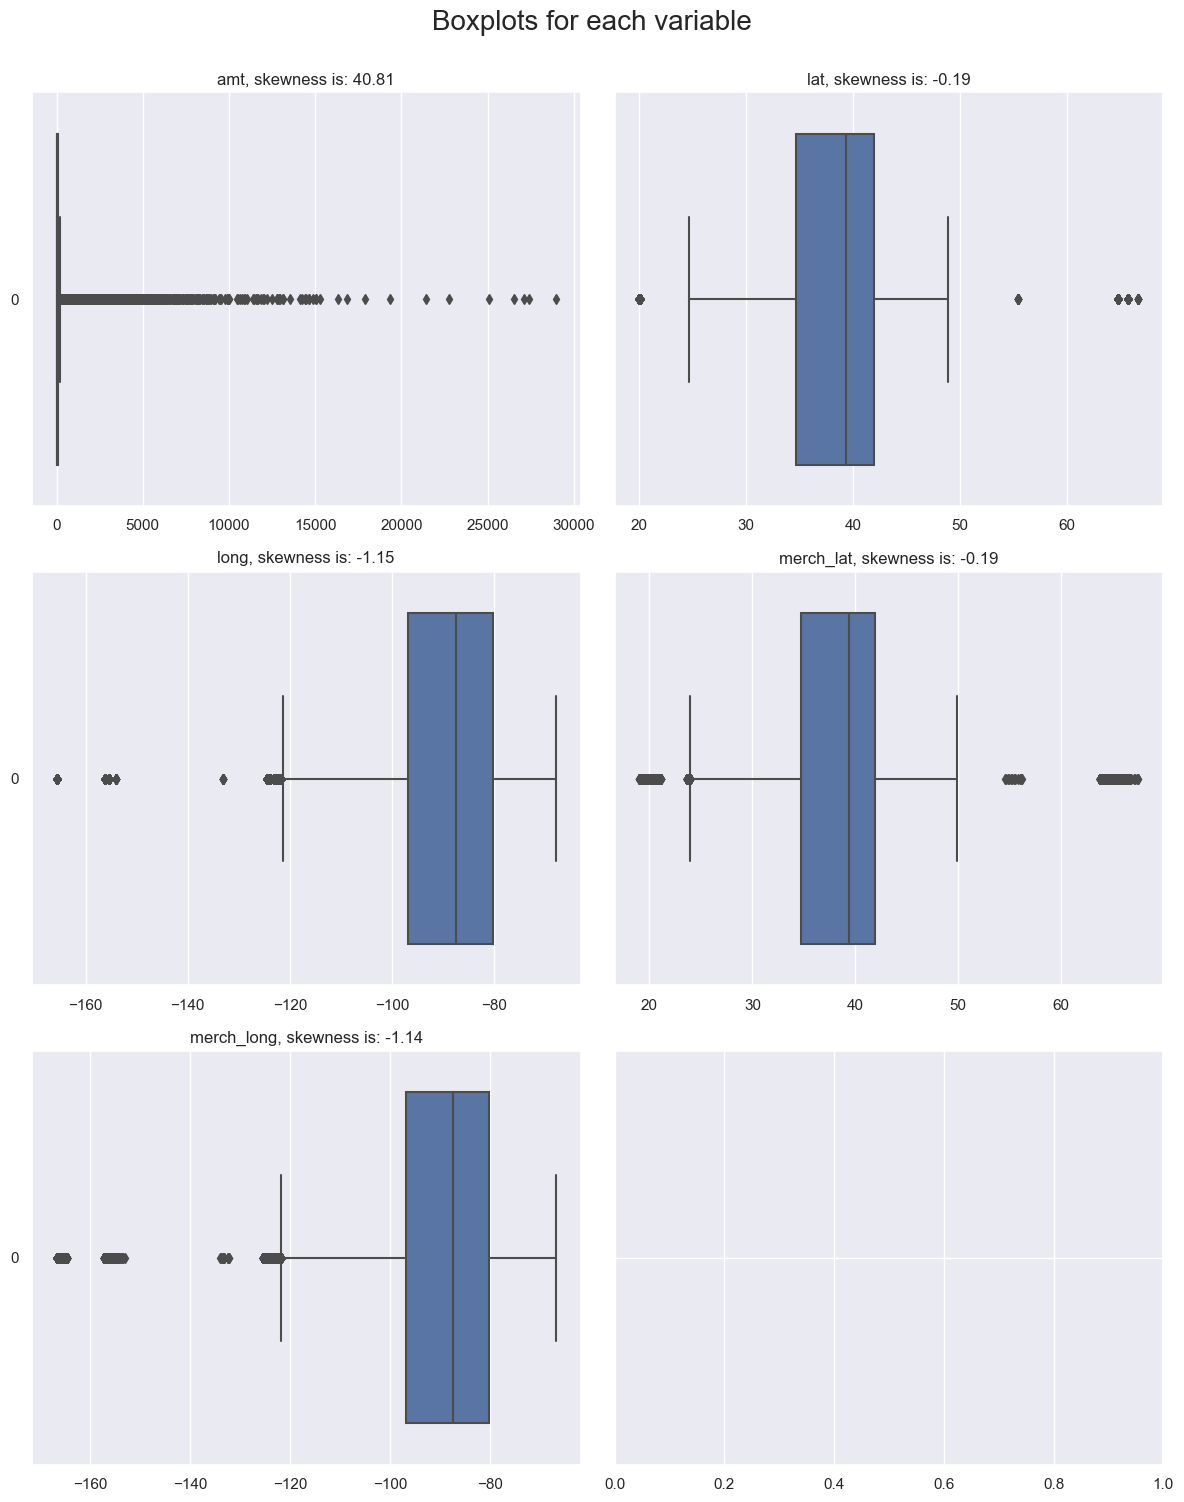

In [ ]:
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(12,15))
    fig.suptitle(suptitle,y=1, size=20)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))

boxplots_custom(dataset=df, columns_list=num_cols, rows=3, cols=2, suptitle='Boxplots for each variable')
plt.tight_layout()

<Axes: >

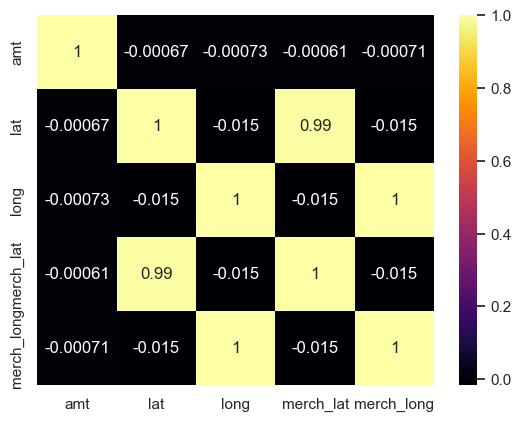

In [ ]:
sns.heatmap(df[num_cols].corr(), annot=True, cmap='inferno')

In [ ]:
df['gender'] = df['gender'].map({'M': 0, 'F': 1})

In [ ]:
df['time'] = pd.to_datetime(df['unix_time'], unit='s')

In [ ]:
df = df.drop(['last', 'first', 'unix_time'], axis=1)